In [26]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, recall_score, precision_score, make_scorer, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [27]:
train_df = pd.read_csv("../Train_Set.csv")
test_df = pd.read_csv("../Test_Set.csv")

X_train, y_train = train_df.drop(columns=["class_label"]), (train_df["class_label"] == "cancer").astype(int)
X_test , y_test  = test_df.drop(columns=["class_label"]) , (test_df["class_label"] == "cancer").astype(int)

In [28]:
# Baseline Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_test_pred = dt.predict(X_test)

print(recall_score(y_test, y_test_pred))      # args are (y_true, y_pred)
print(precision_score(y_test, y_test_pred))

0.8396739130434783
0.9363636363636364


In [29]:
proba = dt.predict_proba(X_test)[:, 1]                      # P(cancer)
prec, rec, thr = precision_recall_curve(y_test, proba)
idx = np.where(rec[:-1] >= 0.95)[0]                      # thresholds align with rec[:-1]
best = idx[np.argmax(prec[idx])]
th  = thr[best]

y_pred = (proba >= th).astype(int)
print(f"threshold  : {th:.3f}")
print(f"recall     : {recall_score(y_test, y_pred):.3f}")
print(f"precision  : {precision_score(y_test, y_pred):.3f}\n")

print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1,0]),
                   index=["actual_cancer", "actual_healthy"],
                   columns=["pred_cancer", "pred_healthy"]))

threshold  : 0.000
recall     : 1.000
precision  : 0.900

                pred_cancer  pred_healthy
actual_cancer           368             0
actual_healthy           41             0


In [30]:
# Use GridSearch to find optimal hyperparameter
param = {
    "max_depth":     [None, 12, 20],
    "min_samples_leaf": [1, 5],
    "class_weight":  [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, "balanced"]
}

recall1 = make_scorer(recall_score, pos_label=1)

dt = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param,
        scoring=recall1,
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=0
     ).fit(X_train, y_train).best_estimator_

In [31]:
proba = dt.predict_proba(X_test)[:, 1]                      # P(cancer)
precision, recall, threshold = precision_recall_curve(y_test, proba)
idx = np.where(recall[:-1] >= 0.95)[0]                      # thresholds align with rec[:-1]
best = idx[np.argmax(precision[idx])]
th  = threshold[best]

y_pred = (proba >= th).astype(int)
print(f"threshold  : {th:.3f}")
print(f"recall     : {recall_score(y_test, y_pred):.3f}")
print(f"precision  : {precision_score(y_test, y_pred):.3f}\n")

print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1,0]),
                   index=["actual_cancer", "actual_healthy"],
                   columns=["pred_cancer", "pred_healthy"]))

threshold  : 0.600
recall     : 0.962
precision  : 0.937

                pred_cancer  pred_healthy
actual_cancer           354            14
actual_healthy           24            17


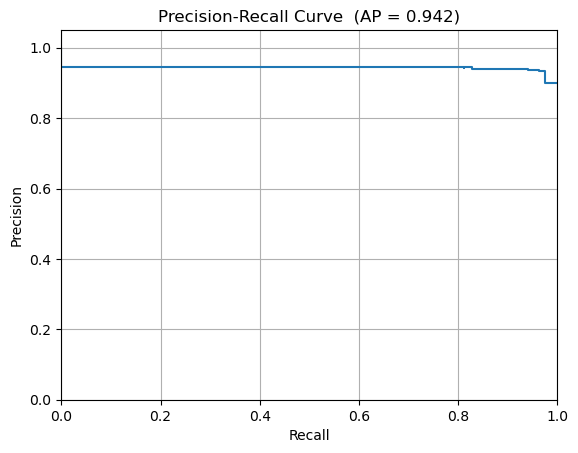

In [32]:
ap = average_precision_score(y_test, proba)

plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve  (AP = {ap:.3f})")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.show()